In [132]:
import numpy as np
import pandas as pd
import requests
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from selenium import webdriver
from selenium.webdriver.common.by import By
import ast
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer, cosine_distance
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report

In [11]:
import requests
import pandas as pd

def get_data():
    api_endpoint ='https://api.indeed.com/ads/apisearch'

    params = {
        'publisher': '448947293830904',
        'q': 'SDE',
        'l': 'ny',
        'jt': 'fulltime',
        'limit': 25,
        'start': 0 ,
        'radius': 100,
        'co': 'us',
        'userip': '1.2.3.4',
        'format': 'json',
        'useragent': 'Chrome',
        'v': 2
    }

    rows = []
    for i in range(40):
        response = requests.get(api_endpoint, params=params)
        rows.extend(response.json()['results'])

        params['start'] += 25

    tb = pd.DataFrame(rows)
    tb.to_csv('db.csv')

    

In [12]:
get_data()

In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By

def get_description(page_url):
    
    
    # enter your codes here
    executable_path = '/opt/homebrew/bin/chromedriver'

    driver = webdriver.Chrome(executable_path=executable_path)

    driver.get(page_url)

    description = driver.find_element(By.CSS_SELECTOR, "div.jobsearch-jobDescriptionText")
    
    return description.text

In [8]:
db = pd.read_csv("db.csv",header=0,index_col=0)

db.drop(columns="indeedApply")
db.drop(columns="stations")
db.drop(columns="refNum")
db.drop(columns="onmousedown")
db.drop(columns="advertiserId")

description = []

for i in range(len(db)):
    description.append(get_description(db.url[i]))
db['description'] = description

db.to_csv('db_with_description.csv')

/var/folders/dc/wvln0gc568s99mg6ck45xlfc0000gn/T/ipykernel_17315/423266675.py:10: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path=executable_path)


In [30]:
keywords = ['c', 'c++', 'c#', 'java', 'javascript', 'python', 'go', 'sql', 'nosql', 'redis', 'html', 'css', 'react', 'angular', 'vue', 'ruby', 'node.js', 'aws', 'django', '.net', 'redux', 'next.js', 'xml']

In [28]:
def tokenize(text):

    li = text.split()

    puncs = "!$%&'()*, -/:;<=>?@[\]^_`{|}~]"
    li2 = []

    for i in range(len(li)):
        li2.extend(li[i].split('/'))

    vocab = []
    for i in range(len(li2)):
        vocab.extend(li2[i].split('-'))
    
    for i in range(len(vocab)):
        vocab[i].strip()
        vocab[i] = ''.join(ch for ch in vocab[i] if ch not in puncs and ch != '"')
        vocab[i] = vocab[i].lower()
    
    return vocab

In [39]:
db = pd.read_csv("db_with_description.csv",header=0,index_col=0)
skills = []
for i in range(len(db)):
    vocab = tokenize(db.description[i])
    requires = []
    for word in vocab:
        if word in keywords:
            requires.append(word)
    requires = list(set(requires))
    skills.append(requires)
db['skills'] = skills
db.to_csv('db_with_skills.csv')


In [53]:
db = pd.read_csv("db_with_skills.csv",header=0,index_col=0)
titles = db['jobtitle']
processed_titles = []
for i in range(len(titles)):
    title = tokenize(titles[i])
    if 'back' in title or 'backend' in title:
        processed_titles.append('back end')
    elif 'front' in title or 'frontend' in title:
        processed_titles.append('front end')
    elif 'software' in title:
        processed_titles.append('software developer')
    else:
        if 'developer' in title:
            index = title.index('developer')
            processed_titles.append(' '.join(title[0:index + 1]))
        elif 'engineer' in title:
            index = title.index('engineer')
            processed_titles.append(' '.join(title[0:index + 1]))
        else:
            processed_titles.append(titles[i])
db['jobtitle'] = processed_titles
db.to_csv('final_db.csv')

In [129]:
import numpy as np
import ast

def get_dict():
    db = pd.read_csv("final_db.csv",header=0,index_col=0)

    dtm = np.zeros((len(db), len(keywords)))
    for i in range(len(db)):
        skills = ast.literal_eval(db.skills[i])
        for skill in skills:
            j = keywords.index(skill)
            dtm[i][j] = 1
    total = dtm.sum(axis=0)
    index = np.argsort(total)
    word = []
    for i in index:
        word.append(keywords[i])
    value = total[index]
    dic = dict(zip(word, value))
    output = sorted(dic.items(), key = lambda item: item[1], reverse=True)
    return dic, output

skill_dict, output = get_dict()
output

[('java', 377.0),
 ('javascript', 335.0),
 ('python', 291.0),
 ('sql', 287.0),
 ('aws', 242.0),
 ('react', 199.0),
 ('css', 193.0),
 ('html', 161.0),
 ('c++', 136.0),
 ('angular', 119.0),
 ('c#', 119.0),
 ('go', 105.0),
 ('c', 104.0),
 ('.net', 92.0),
 ('nosql', 75.0),
 ('xml', 56.0),
 ('node.js', 54.0),
 ('ruby', 40.0),
 ('redux', 32.0),
 ('vue', 30.0),
 ('django', 26.0),
 ('redis', 26.0),
 ('next.js', 6.0)]

In [11]:
import PyPDF2

def read_pdf(file_name = 'resume.pdf'):
    with open(file_name, 'rb') as file:
        pdf_reader = PyPDF2.PdfFileReader(file)

        text = ""
        for page in range(pdf_reader.numPages):
            page_obj = pdf_reader.getPage(page)
            text += page_obj.extractText()
    return text


In [13]:

import spacy
import re
nlp = spacy.load("en_core_web_sm")

def preprocess(doc, lemmatized = True, pos_tag = False, remove_stopword = True, lower_case = True, remove_punctuation = True):
    for i in range(len(doc)):
        doc[i] = nlp(doc[i].replace('\n\n', '. '))
    sents = doc
    tokenized_sents = list(map(lambda sent: preprocess_token(sent, lemmatized, pos_tag, remove_stopword, lower_case, remove_punctuation), doc))
            
    return sents, tokenized_sents

def preprocess_token(sent, lemmatized, pos_tag, remove_stopword, lower_case, remove_punctuation):
    tokenized_sent = []
    for token in sent:
        text = token.text
        if lemmatized:
            text = token.lemma_

        if remove_stopword:
            if token.is_stop:
                continue

        if remove_punctuation:
            if token.is_punct:
                continue

        if bool(re.search("^\s*$", token.text)):
            continue

        if lower_case:
            text = text.lower()

        if pos_tag:
            text = (text, token.pos_)

        tokenized_sent.append(text)

    return tokenized_sent

In [12]:
sents, tokenized_sents = preprocess(read_pdf())

for i in range(3):
    print(sents[i], "\n",tokenized_sents[i],"\n\n" )

SHIHAO XIONG shihao.xiong@icloud.com   |  (551) 556 - 4100   |   Jersey City, NJ 07302  GitHub: https://github.com/sxiong5 | Linkedin: https://www.linkedin.com/in/sxiong5 SUMMARY      Seeking a Software Engineer. 
 ['shihao', 'xiong', 'shihao.xiong@icloud.com', '|', '551', '556', '4100', '|', 'jersey', 'city', 'nj', '07302', 'github', 'https://github.com/sxiong5', '|', 'linkedin', 'https://www.linkedin.com/in/sxiong5', 'summary', 'seek', 'software', 'engineer'] 


Master degree candidate. 
 ['master', 'degree', 'candidate'] 


A wide range of project experience in web programming. 
 ['wide', 'range', 'project', 'experience', 'web', 'programming'] 




In [18]:
def compute_tf_idf(sents, use_idf = True, min_df = 1):
   
    #add your codes
    docs_tokens = {idx:{token:tokens.count(token) for token in set(tokens)} for idx, tokens in enumerate(sents)}

    dtm=pd.DataFrame.from_dict(docs_tokens, orient="index")
    dtm=dtm.fillna(0)
    dtm = dtm.sort_index(axis = 0)

    tf=dtm.values
    doc_len=tf.sum(axis=1, keepdims=True)
    tf=np.divide(tf, doc_len)
    
    df=np.where(tf>0,1,0)

    smoothed_idf=np.log(np.divide(len(sents)+1, np.sum(df, axis=0)+1))+1    
    tf_idf=normalize(tf*smoothed_idf)
    
    
    if use_idf:
        return tf_idf
    else:
        return tf

['software developer', 'software developer', 'front end', 'software developer', 'software developer', 'react js developer', 'full stack .net developer', 'ios developer', 'python senior developer', 'software developer', 'software developer', 'java developer', 'java developer', 'software developer', 'software developer', 'software developer', 'software developer', 'front end', 'front end', 'vice president engineering core developer', 'software developer', 'senior java developer', 'web developer', 'web developer', 'javascript engineer', 'software developer', 'Sr. Engineering Manager', 'developer', 'sr. java developer', 'web developer', 'application developer', 'java cloud developer', 'software developer', 'senior developer', 'Programmer/Analyst', 'software developer', 'software developer', 'full stack engineer', 'python developer', 'software developer', 'full stack developer', 'software developer', 'software developer', 'software developer', 'software developer', 'front end', 'contractor 

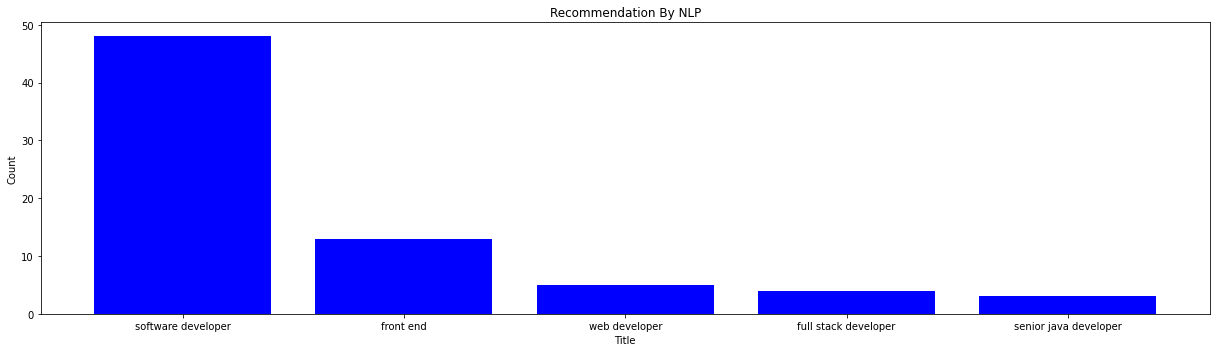

In [121]:
def get_recommendation_by_similarity():
    data = pd.read_csv("final_db.csv")
    description = list(data["description"])
    description.append(read_pdf())
    doc = description
    sents, tokenized_sents = preprocess(doc)
    tf_idf = compute_tf_idf(tokenized_sents, use_idf = True)
    similarity=1-pairwise_distances(tf_idf, metric = 'cosine')
    similarity_to_resume = similarity[len(similarity) - 1,:][:len(similarity) - 1]
    index = np.argsort(np.array(similarity_to_resume))[-100:]
    job_titles = list(map(lambda idx:data["jobtitle"][idx], index))

    return job_titles

    

recommend = get_recommendation_by_similarity()

print(recommend)

res = dict()

for title in recommend:
    res[title] = res.get(title, 0) + 1


res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

title = list(res.keys())[:5]
count = list(res.values())[:5]

indices = np.arange(5) 
plt.figure(figsize=(17,5)) 
plt.bar(indices, count, color='b') 
plt.title('Recommendation By NLP') 
plt.xlabel('Title') 
plt.ylabel('Count') 
plt.xticks(indices, title, rotation='horizontal') 
plt.tight_layout() 
plt.show()

['software developer', 'opensource javascript react developer', 'software developer', 'software developer', 'full stack engineer', 'full stack developer', 'full stack developer', 'front end', 'senior react developer', 'front end', 'software developer', 'front end', 'full stack java developer', 'Programmer/Analyst', 'software developer', 'mobile developer', 'full stack engineer', 'software developer', 'software developer', 'software developer', 'front end', 'front end', 'software developer', 'senior web developer', 'web developer', 'lead web developer', 'software developer', 'lead web developer', 'software developer', 'software developer', 'back end', 'full stack engineer', 'front end', 'senior full stack java developer', 'software developer', 'full stack engineer', 'software developer', 'software developer', 'front end', 'software developer', 'software developer', 'software developer', 'software developer', 'software developer', 'software developer', 'software developer', 'software dev

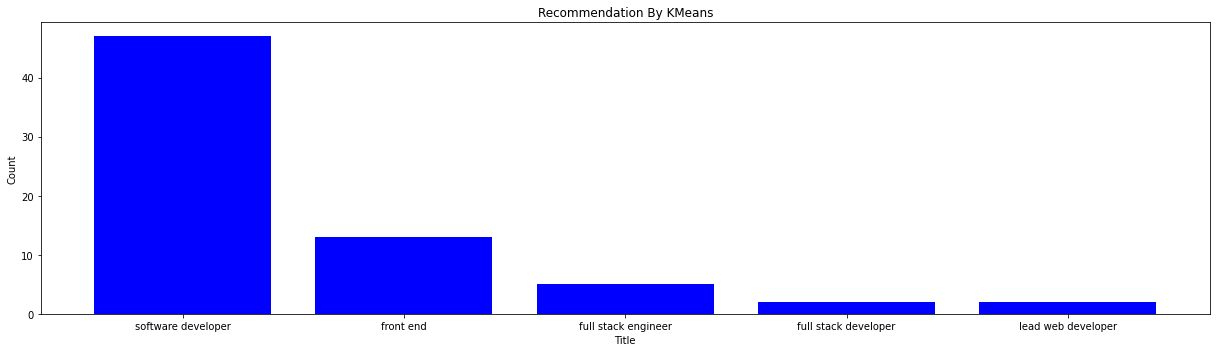

In [120]:
def recommend_by_cluster():
    data = pd.read_csv("final_db.csv")
    skills = []
    for i in range(len(data)):
        skills_p = ast.literal_eval(data.skills[i])
        skills_str = ""
        for skill in skills_p:
            skills_str = skills_str + skill + ", "
        if skills_str == "":
            skills.append("none")
        else:
            skills.append(skills_str[0:len(skills_str) - 2])

    vocab = tokenize(read_pdf())
    requires = []
    for word in vocab:
        if word in keywords:
            requires.append(word)
    requires = list(set(requires))
    resume_skill = ""
    for skill in requires:
            resume_skill = resume_skill + skill + ", "
    skills.append(resume_skill[0:len(resume_skill) - 2])

    tfidf_vect = TfidfVectorizer(stop_words="english", min_df=1)
    dtm = tfidf_vect.fit_transform(skills)

    num_clusters=10

    # clusterer = KMeansClusterer(num_clusters, cosine_distance, repeats = 40)
    # clusters = clusterer.cluster(dtm.toarray(), assign_clusters = True)
    km = KMeans(n_clusters=num_clusters, n_init=20, random_state = 42)\
    .fit(dtm[:-1])
    clusters = km.labels_.tolist()
    
    resume_dtm = dtm[-1]
    pred = km.predict(resume_dtm)


    same_cluster = []
    for i in range(len(clusters)):
        if clusters[i] == pred:
            same_cluster.append(i)

    job_titles = list(map(lambda idx:data["jobtitle"][idx], same_cluster))

    return job_titles

recommend = list(recommend_by_cluster())

print(recommend)

res = dict()

for title in recommend:
    res[title] = res.get(title, 0) + 1


res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

title = list(res.keys())[:5]
count = list(res.values())[:5]

indices = np.arange(5) 
plt.figure(figsize=(17,5)) 
plt.bar(indices, count, color='b') 
plt.title('Recommendation By KMeans') 
plt.xlabel('Title') 
plt.ylabel('Count') 
plt.xticks(indices, title, rotation='horizontal') 
plt.tight_layout() 
plt.show()



    

In [152]:
def label() :
    db = pd.read_csv("final_db.csv",header=0,index_col=0)

    values = list(skill_dict.values())
    sum = 0
    for value in values:
        sum = sum + value
    avg = sum / len(values)

    label = []

    for i in range(len(db)):
        skills = ast.literal_eval(db.skills[i])
        count = 0
        for skill in skills:
            count = count + skill_dict.get(skill)
        if count != 0:
            skill_avg = count / len(skills)
        else:
            skill_avg = 0
        if skill_avg >= avg:
            label.append(1)
        else:
            label.append(0)
    
    db["label"] = label
    db.to_csv('labeled.csv')
    return avg

def create_model(train_docs, train_y, test_docs, test_y, tokenizer=None,
                 model_type="svm", min_df = 1,stop_words=None, 
                 print_result = True, algorithm_para=1.0):
    
    tfidf_vect = TfidfVectorizer(tokenizer=tokenizer, stop_words=stop_words, min_df=min_df)
    train_x = tfidf_vect.fit_transform(train_docs)

    if model_type == 'nb':
        clf = MultinomialNB(alpha=algorithm_para)
    elif model_type == 'svm':
        clf = svm.LinearSVC(C=algorithm_para)
    clf.fit(train_x, train_y)

    test_x = tfidf_vect.transform(test_docs)
    predicted = clf.predict(test_x)

    if model_type=='nb':
        predict_p = clf.predict_proba(test_x)
        y_pred = predict_p[:,1]
        fpr, tpr, thresholds = roc_curve(test_y, y_pred, pos_label=1)
        precision, recall, thresholds = precision_recall_curve(test_y, y_pred, pos_label=1)       
    elif model_type=='svm':
        decision_scores = clf.decision_function(test_x)
        fpr, tpr, thresholds = roc_curve(test_y, decision_scores, pos_label=1)
        precision, recall, thresholds = precision_recall_curve(test_y, decision_scores, pos_label=1)
    
    auc_score = auc(fpr, tpr)
    prc_score = auc(recall, precision)

    if print_result:
        # print(classification_report(test_y,predicted,target_names=['0','1']))
        
        print("AUC: {:.2%}".format(auc_score)+" PRC: {:.2%}".format(prc_score))

        plt.figure();
        plt.plot(fpr, tpr, color='darkorange', lw=2);
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
        plt.xlim([0.0, 1.0]);
        plt.ylim([0.0, 1.05]);
        plt.xlabel('False Positive Rate');
        plt.ylabel('True Positive Rate');
        plt.title(model_type+'-AUC');
        plt.show();

        plt.figure();
        plt.plot(recall, precision, color='darkorange', lw=2);
        plt.xlim([0.0, 1.0]);
        plt.ylim([0.0, 1.05]);
        plt.xlabel('Recall');
        plt.ylabel('Precision');
        plt.title(model_type+'-PRC');
        plt.show();

    # add your code here

    return auc_score, prc_score

avg = label()

AUC: nan% PRC: 100.00%


/Users/chenfeiyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


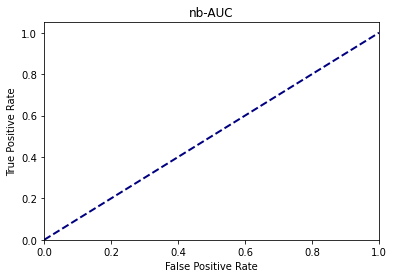

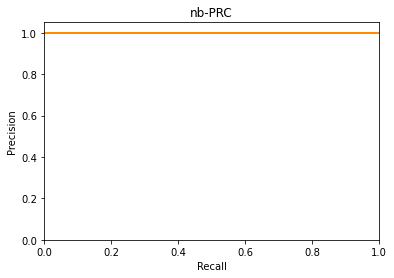

AUC: nan% PRC: 100.00%


/Users/chenfeiyu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


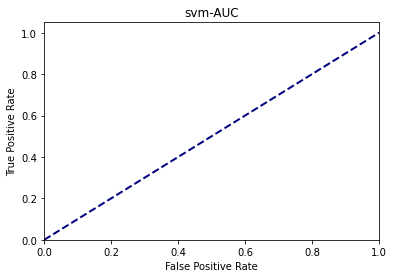

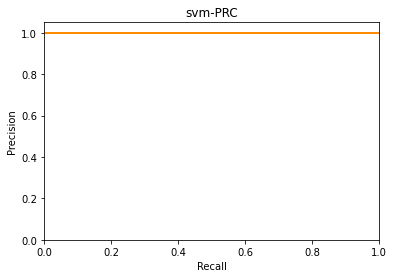

In [153]:
db = pd.read_csv("labeled.csv",header=0,index_col=0)

resume = read_pdf()

vocab = tokenize(read_pdf())
requires = []
for word in vocab:
    if word in keywords:
        requires.append(word)
requires = list(set(requires))
count = 0
for skill in requires:
        count = count + skill_dict.get(skill)
resume_avg = count / len(requires)
if resume_avg >= avg:
        resume_label = 1
else:
        resume_label = 0

df = pd.DataFrame([(resume, resume_label)], columns=['text', 'label'])



auc_score, prc_socre = create_model(db["description"], db["label"], df["text"], df["label"], \
            tokenizer=None,model_type='nb',  min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)

auc_score, prc_socre = create_model(db["description"], db["label"], df["text"], df["label"], \
            tokenizer=None,model_type='svm', min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)